# EDA on Processed Training Data

This notebook inspects the output of the `generate_dataset` Beam pipeline. We will check data quality, distributions, and relationships between features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

sns.set_theme(style="whitegrid")
%matplotlib inline

## 1. Load Data
Loading the locally downloaded parquet file (downloaded from GCS output).

In [2]:
DATA_PATH = '../local_artifacts/processed_data/training_data.parquet'

try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"File not found at {DATA_PATH}. Please ensure you have downloaded the data from GCS.")

Loaded dataset with 75390 rows and 20 columns.


## 2. Basic Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75390 entries, 0 to 75389
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_uid             75390 non-null  object 
 1   trip_date            75390 non-null  object 
 2   arrival_time         75390 non-null  object 
 3   timestamp            75390 non-null  float64
 4   group_id             75390 non-null  object 
 5   route_id             75390 non-null  object 
 6   direction            75390 non-null  object 
 7   stop_id              75390 non-null  object 
 8   time_idx             75390 non-null  int64  
 9   day_of_week          75390 non-null  int64  
 10  hour_sin             75390 non-null  float64
 11  hour_cos             75390 non-null  float64
 12  regime_id            75390 non-null  object 
 13  track_id             75390 non-null  object 
 14  service_headway      75386 non-null  float64
 15  preceding_train_gap  75388 non-null 

In [4]:
df.head()

,trip_uid,trip_date,arrival_time,timestamp,group_id,route_id,direction,stop_id,time_idx,day_of_week,hour_sin,hour_cos,regime_id,track_id,service_headway,preceding_train_gap,empirical_median,travel_time_14th,travel_time_23rd,travel_time_34th
0,1760306220_C..S,2025-10-12 21:57:00+00:00,2025-10-13T02:27:02+00:00,1.760322e+09,C_South,C,S,A32S,29338707,0,0.598325,0.801254,Night,A3,-74292.483333,NaN,-35338.116667,NaN,NaN,NaN
1,1760212080_C..S,2025-10-11 19:48:00+00:00,2025-10-12T00:15:17+00:00,1.760228e+09,C_South,C,S,A32S,29337135,6,0.065403,0.997859,Night,A3,98115.200000,-1571.750000,-32708.866667,NaN,NaN,NaN
2,1760465580_C..S04R,2025-10-14 18:13:00+00:00,2025-10-14T22:43:17+00:00,1.760482e+09,C_South,C,S,A32S,29341363,1,-0.329691,0.944089,Night,A3,-25205.466667,4228.000000,-42580.750000,NaN,NaN,NaN
3,1763034990_C..S04R,2025-11-13 11:56:30+00:00,2025-11-13T17:28:32+00:00,1.763055e+09,C_South,C,S,A32S,29384248,3,-0.990268,-0.139173,Day,A3,-27225.900000,42885.250000,-40545.291667,NaN,NaN,NaN
4,1760207610_C..S,2025-10-11 18:33:30+00:00,2025-10-11T23:01:25+00:00,1.760224e+09,C_South,C,S,A32S,29337061,5,-0.254602,0.967046,Night,A3,-22629.100000,-47187.116667,-49896.883333,NaN,NaN,NaN


## 3. Data Quality Checks
Checking for null values in key columns.

In [5]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0]

service_headway            4
preceding_train_gap        2
travel_time_14th       75390
travel_time_23rd       75390
travel_time_34th       75390
dtype: int64

### Check Target Variable (`service_headway`)

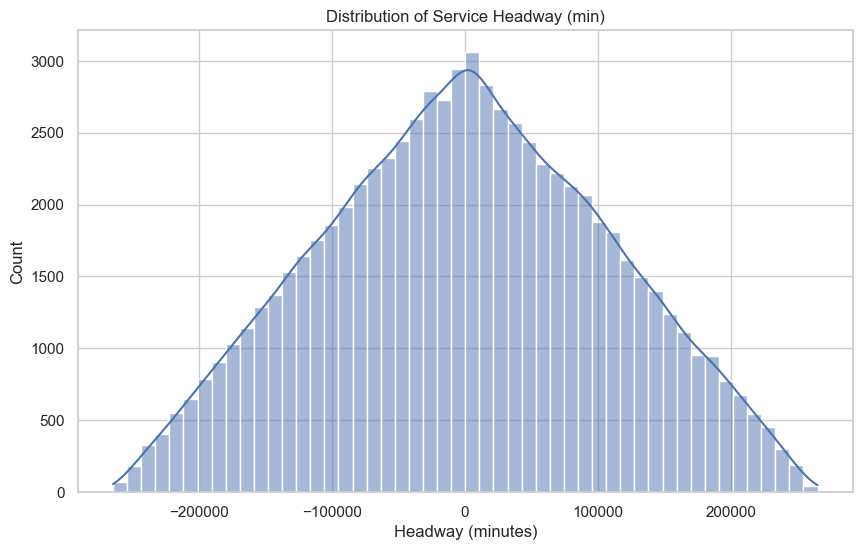

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['service_headway'], bins=50, kde=True)
plt.title('Distribution of Service Headway (min)')
plt.xlabel('Headway (minutes)')
plt.show()

In [7]:
print("Headway Statistics:")
df['service_headway'].describe()

Headway Statistics:


count     75386.000000
mean         -2.298844
std      108418.811158
min     -265083.066667
25%      -77861.991667
50%         136.958333
75%       78365.050000
max      265331.700000
Name: service_headway, dtype: float64

## 4. Feature Relationships
Analyzing the relationship between valid existing travel times and the target headway.

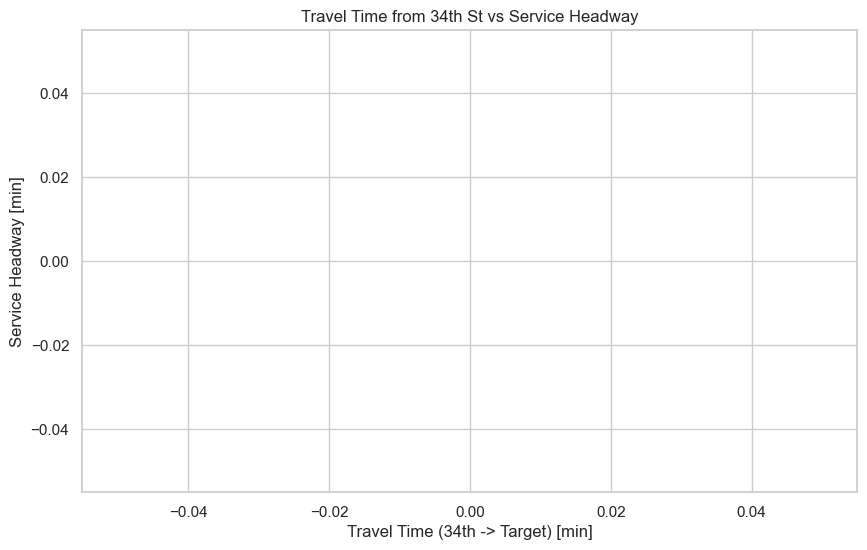

In [8]:
# Filter for rows where travel_time_34th is not null
valid_tt = df.dropna(subset=['travel_time_34th'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_tt, x='travel_time_34th', y='service_headway', alpha=0.5)
plt.title('Travel Time from 34th St vs Service Headway')
plt.xlabel('Travel Time (34th -> Target) [min]')
plt.ylabel('Service Headway [min]')
plt.show()

### Correlation Matrix

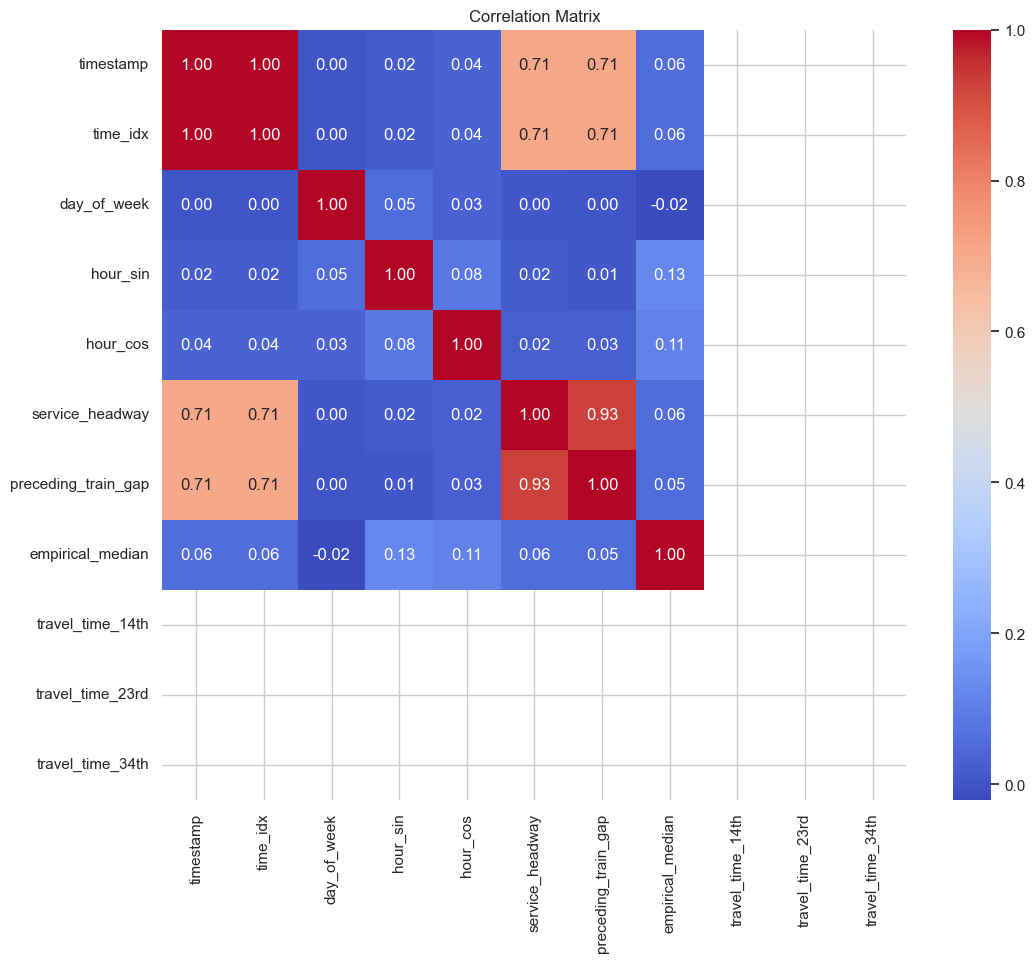

In [9]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 5. Temporal Analysis

In [ ]:
try:
    # Convert arrival_time back to datetime for plotting
    df['dt'] = pd.to_datetime(df['arrival_time'])
    
    # Plot headway over time for a sample day
    sample_day = df['dt'].dt.date.iloc[0]
    daily_data = df[df['dt'].dt.date == sample_day].sort_values('dt')
    
    plt.figure(figsize=(15, 6))
    plt.plot(daily_data['dt'], daily_data['service_headway'], marker='o')
    plt.title(f'Headway over Time on {sample_day}')
    plt.ylabel('Headway (min)')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot time series: {e}")